# Probabilities of recombination

In [4]:
from __future__ import division, print_function
from IPython.display import display, HTML, Math, Latex
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import log, sqrt, factorial
from scipy import stats, optimize

## gDNA sequences

The two graph below are showing the allowed value of $p_r$ and $p_r^{\prime}$, computed using the gdna data.

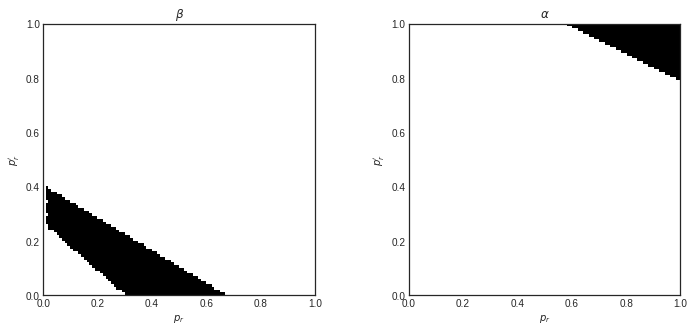

In [4]:
def pf(pr, prp, pc, p_nc_obs):
    return 1./(2.*pc*pr + 1e-8)*(2*pr+1+prp - (pr+prp)*(1-pc)*(1./p_nc_obs))

def p_prod_possible(pc, p_out_observed, err):
    n_grid = 100 # increase for better precision
    img = np.zeros((n_grid,n_grid))
    img.fill(float(0))
    for k in range(n_grid):
        for l in range(n_grid):
            # taking into account the error bar
            for p_out in np.arange(p_out_observed - err,
                                   p_out_observed + err,
                                  1e-3):
                p = pf(l/n_grid, k/n_grid, pc, p_out)
                if p <= 1. and p >= 0.:
                    img[n_grid - 1 - k, l] = 1
                    break
    return img


pc_a = 1 - 2/3 - 0.028
pc_b = 1 - 2/3 - 0.0678

with plt.style.context("seaborn-white"):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))
    img_beta = p_prod_possible(pc_b, 0.18, 0.03)
    img_alpha = p_prod_possible(pc_a, 0.40, 0.01)

    ax1.imshow(img_beta, extent=(0,1,0,1))
    ax2.imshow(img_alpha, extent=(0,1,0,1))
    ax1.grid(False)
    ax2.grid(False)
    ax1.set_title(r"$\beta$")
    ax1.set_xlabel(r"$p_r$")
    ax1.set_ylabel(r"$p_r^{\prime}$")

    ax2.set_title(r"$\alpha$")
    ax2.set_xlabel(r"$p_r$")
    ax2.set_ylabel(r"$p_r^{\prime}$")
    plt.savefig("gdna_results.pdf")
    plt.show()

## RNA sequences

This section creates figure S7.

In [7]:
vE = {}
vInin = {}
vOut = {}
for exp in ["exp3", "exp2", "exp1"]:
    filepairsaa = "../Datas/"+exp+"/pairs_aa.tsv.gz"
    dfaa = pd.read_csv(filepairsaa, sep="\t")
    df = dfaa[dfaa.distance > 10] # remove the identical pairs 
    vE[exp] = np.concatenate((df[(df.status_1 == "In") & (df.status_2 == "Out")].copy_1.values,
                        df[(df.status_2 == "In") & (df.status_1 == "Out")].copy_2.values))
    vInin[exp] = np.concatenate((df[(df.status_1 == "In") & (df.status_2 == "In")].copy_1.values,
                       df[(df.status_1 == "In") & (df.status_2 == "In")].copy_2.values))
    vOut[exp] = np.concatenate((df[(df.status_2 == "Out") & (df.status_1 == "In")].copy_2.values,
                       df[(df.status_1 == "Out") & (df.status_2 == "In")].copy_1.values))

Nmin = 0
Nmax = 4000
lvE = {}
lvInin = {}
lvOut = {}
for lv, v in zip([lvOut, lvE, lvInin], [vOut, vE, vInin]):
    for exp in ["exp3", "exp2", "exp1"]:
        lv[exp] = np.log(v[exp])


Exp 2, best fit with kss (log):  0.6630000000000001
Exp 3, best fit with kss (log):  0.7030000000000002
Exp 2, best fit with kss:  0.6590000000000001
Exp 3, best fit with kss:  0.6750000000000002
Exp 2, best fit with eds:  0.6560000000000001
Exp 3, best fit with eds:  0.7230000000000002
Exp 2, best fit with eds (log):  0.6670000000000001
Exp 3, best fit with eds (log):  0.7030000000000002
Exp 2, best parameter with mean:  0.7072558488250877
Exp 3, best parameter with mean:  0.7818591635750533
Exp 2, best parameter with mean (of log):  0.6666712026754736
Exp 3, best parameter with mean (of log):  0.7026628268550086


/home/tautilde/.local/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/tautilde/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


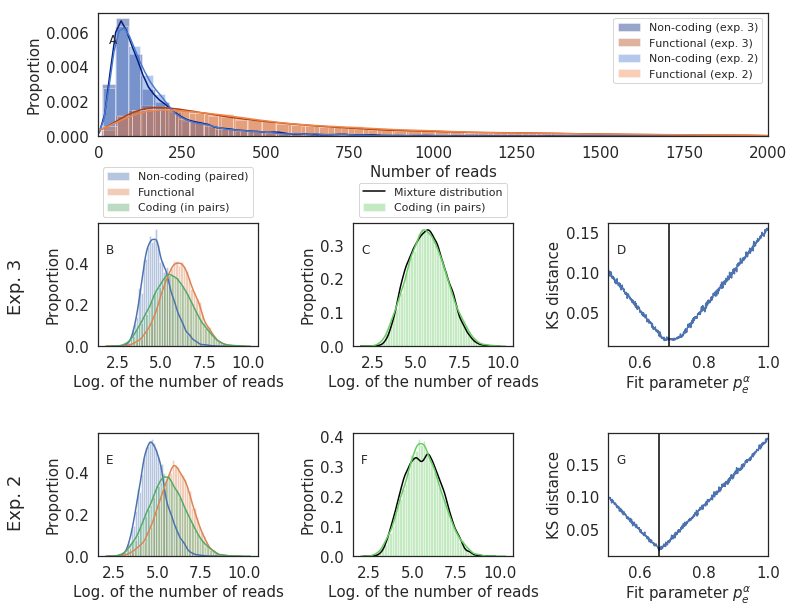

In [9]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes



fig = plt.figure(figsize=(12, 10))

gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])
ax7 = plt.subplot(gs[2, 2])

gs.update(wspace = 0.6, hspace=0.7)

pald = sns.color_palette("dark")
palm = sns.color_palette("muted")

sns.distplot(vOut["exp3"][vOut["exp3"] <= 2000], ax=ax1, label="Non-coding (exp. 3)", color=pald[0])
sns.distplot(vE["exp3"][vE["exp3"] <= 2000], ax=ax1, label="Functional (exp. 3)", color=pald[1])
sns.distplot(vOut["exp2"][vOut["exp2"] <= 2000], ax=ax1, label="Non-coding (exp. 2)", color=palm[0])
sns.distplot(vE["exp2"][vE["exp2"] <= 2000], ax=ax1, label="Functional (exp. 2)", color=palm[1])
ax1.set_xlim(0, 2000)
ax1.legend()
ax1.set_xlabel("Number of reads")
ax1.set_ylabel("Proportion")

sns.distplot(lvOut["exp3"], ax=ax2, label="Non-coding (paired)")
sns.distplot(lvE["exp3"], ax=ax2, label="Functional")
sns.distplot(lvInin["exp3"], ax=ax2, label="Coding (in pairs)")
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
ax2.set_xlabel("Log. of the number of reads")
ax2.set_ylabel("Proportion")

sns.distplot(lvOut["exp2"], ax=ax4, label="Non-coding (paired)")
sns.distplot(lvE["exp2"], ax=ax4, label="Functional")
sns.distplot(lvInin["exp2"], ax=ax4, label="Coding (in pairs)")
ax4.set_xlabel("Log. of the number of reads")
ax4.set_ylabel("Proportion")




ps = np.arange(0.5, 1., 0.001)
kss_nonlog = {"exp2": np.zeros(ps.shape), "exp3": np.zeros(ps.shape)}
eds_nonlog = {"exp2": np.zeros(ps.shape), "exp3": np.zeros(ps.shape)}
kss = {"exp2": np.zeros(ps.shape), "exp3": np.zeros(ps.shape)}
eds = {"exp2": np.zeros(ps.shape), "exp3": np.zeros(ps.shape)}
N = 50000
for exp in ["exp2", "exp3"]:
    vT = lvInin[exp]#np.random.choice(vInin[exp], N)
    for i, p in enumerate(ps):
        vB = np.concatenate([np.random.choice(lvOut[exp], int(N*(1-p)), replace=True),
                         np.random.choice(lvE[exp], int(N*(p)), replace=True)])
        vB_nonlog = np.concatenate([np.random.choice(vOut[exp], int(N*(1-p)), replace=True),
                         np.random.choice(vE[exp], int(N*(p)), replace=True)])
        kss_nonlog[exp][i] = stats.ks_2samp(vInin[exp], vB_nonlog)[0]
        kss[exp][i] = stats.ks_2samp(vT, vB)[0]
        eds[exp][i] = stats.energy_distance(vT, vB) # nearly identical results with a different distance
        eds_nonlog[exp][i] = stats.energy_distance(vInin[exp], vB_nonlog) 

print("Exp 2, best fit with kss (log): ", ps[np.argmin(kss["exp2"])])
print("Exp 3, best fit with kss (log): ", ps[np.argmin(kss["exp3"])])
print("Exp 2, best fit with kss: ", ps[np.argmin(kss_nonlog["exp2"])])
print("Exp 3, best fit with kss: ", ps[np.argmin(kss_nonlog["exp3"])])
print("Exp 2, best fit with eds: ", ps[np.argmin(eds_nonlog["exp2"])])
print("Exp 3, best fit with eds: ", ps[np.argmin(eds_nonlog["exp3"])])
print("Exp 2, best fit with eds (log): ", ps[np.argmin(eds["exp2"])])
print("Exp 3, best fit with eds (log): ", ps[np.argmin(eds["exp3"])])
print("Exp 2, best parameter with mean: ",
      (np.mean(vInin["exp2"]) - np.mean(vOut["exp2"]))/(np.mean(vE["exp2"]) - np.mean(vOut["exp2"])))
print("Exp 3, best parameter with mean: ", 
      (np.mean(vInin["exp3"]) - np.mean(vOut["exp3"]))/(np.mean(vE["exp3"]) - np.mean(vOut["exp3"])))
print("Exp 2, best parameter with mean (of log): ",
      (np.mean(lvInin["exp2"]) - np.mean(lvOut["exp2"]))/(np.mean(lvE["exp2"]) - np.mean(lvOut["exp2"])))
print("Exp 3, best parameter with mean (of log): ", 
      (np.mean(lvInin["exp3"]) - np.mean(lvOut["exp3"]))/(np.mean(lvE["exp3"]) - np.mean(lvOut["exp3"])))

ax6.plot(ps, kss_nonlog["exp3"], label="KS distance")
# energy distance is twice mean square error
# ax6.plot(ps, eds["exp3"]/2, label="Energy distance")
ax6.axvline(0.69, color="black")
ax6.set_xlabel(r"Fit parameter $p_e^{\alpha}$")
ax6.set_ylabel("KS distance")
#ax6.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
# ax6.set_ylim((0, 1.))
ax6.set_xlim((0.5, 1.))

ax7.plot(ps, kss_nonlog["exp2"], label="KS distance")
# ax7.plot(ps, eds["exp2"]/2, label="Mean square error")
ax7.axvline(0.66, color="black")
ax7.set_xlabel(r"Fit parameter $p_e^{\alpha}$")
ax7.set_ylabel("KS distance")
# ax7.set_ylim((0, 1.))
ax7.set_xlim((0.5, 1.))

# ax6.get_legend().remove()
# ax7.get_legend().remove()

p = {"exp3": 0.69, "exp2":0.66}
vB = {}
N = 50000
for exp in ["exp3", "exp2"]:
    vB[exp] = np.concatenate([np.random.choice(lvOut[exp], int(N*(1-p[exp])), replace=True),
                         np.random.choice(lvE[exp], int(N*p[exp]), replace=True)])

    
sns.distplot(vB["exp3"], hist=False, ax=ax3, label="Mixture distribution", color="black")
sns.distplot(lvInin["exp3"], ax=ax3, label="Coding (in pairs)", color=palm[2])
ax3.set_xlabel("Log. of the number of reads")
ax3.set_ylabel("Proportion")
ax3.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
sns.distplot(vB["exp2"], hist=False, ax=ax5, label="Mixture distribution", color="black")
sns.distplot(lvInin["exp2"], ax=ax5, label="Coding (in pairs)", color=palm[2])
ax5.set_xlabel("Log. of the number of reads")
ax5.get_legend().remove()
ax5.set_ylabel("Proportion")
ax3.text(0.05, 0.75, "C", transform=ax3.transAxes)
ax5.text(0.05, 0.75, "F", transform=ax5.transAxes)
ax2.text(0.05, 0.75, "B", transform=ax2.transAxes)
ax4.text(0.05, 0.75, "E", transform=ax4.transAxes)
ax6.text(0.05, 0.75, "D", transform=ax6.transAxes)
ax7.text(0.05, 0.75, "G", transform=ax7.transAxes)
ax1.text(0.016, 0.75, "A", transform=ax1.transAxes)

fig.text(0.03, 0.2, "Exp. 2", rotation=90, ha='center', va='center', fontsize=18)
fig.text(0.03, 0.5, "Exp. 3", rotation=90, ha='center', va='center', fontsize=18)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

fig.tight_layout()
fig.savefig("../../TCR_pairing_paper/figures/S7_fit_distributions.pdf")
fig.show()


### Previous figure S7

In [1]:
# Experiment selection : 
experiment="exp3"

In [2]:
filepairsab = "../Datas/"+experiment+"/pairs_ab.tsv.gz"
filepairsaa = "../Datas/"+experiment+"/pairs_aa.tsv.gz"
filepairsbb = "../Datas/"+experiment+"/pairs_bb.tsv.gz"

In [5]:
N = 1000
Nmin = 10
dfaa = pd.read_csv(filepairsaa, sep="\t")
dfaa = dfaa[(dfaa.nb_wells_1 > 5) & (dfaa.nb_wells_2 > 5) & 
               (dfaa.nb_wells_1 < 70) & (dfaa.nb_wells_2 < 70) &
               (dfaa.distance > 20)]
df = dfaa

nbbins = 100
vOut = np.concatenate((df[df.status_2 == "Out"].copy_2.values,
                       df[df.status_1 == "Out"].copy_1.values))

hOut = np.histogram(vOut, bins=nbbins, range=(Nmin,N), density=True)[0]
vE = df[(df.status_1 == "In") & (df.status_2 == "Out")].copy_1.values
hE = np.histogram(vE, bins=nbbins, range=(Nmin,N), density=True)[0]
vInin = np.concatenate((df[(df.status_1 == "In") & (df.status_2 == "In")].copy_1.values,
                       df[(df.status_1 == "In") & (df.status_2 == "In")].copy_2.values))
hInin = np.histogram(vInin, bins=nbbins, range=(Nmin,N), density=True)[0]


print("length ; vOut : ", len(vOut), ",  vE : ", len(vE), ",  vInin : ", len(vInin))

mini = 1e12
best = (-1, -1)
for p in np.arange(0.,1.,0.01):
    tot = sum([(aIn - p*aOut - (1-p)*aE)**2 for (aIn, aOut, aE)
            in zip(hInin, hOut, hE)])
    if(tot < mini):
        best = (p, 1-p)
        mini = tot

nplin = np.linspace(Nmin,N,nbbins)
fitres = best[0]*hOut + best[1]*hE
p = best[0]
propEE = 1 - 2*p
pm10 = p - 10/100
pp10 = p + 10/100 

print("Proportion of exposed-exposed cells: ", propEE)
print("Best fit: ", best)

hOut = np.histogram(vOut, bins=nbbins, range=(Nmin,N), density=True)[0]
hE = np.histogram(vE, bins=nbbins, range=(Nmin,N), density=True)[0]
hInin = np.histogram(vInin, bins=nbbins, range=(Nmin,N), density=True)[0]
fitresm10 = pm10*hOut + (1-pm10)*hE
fitresp10 = pp10*hOut + (1-pp10)*hE
fitres = p*hOut + (1-p)*hE
nplin = np.linspace(Nmin,N,nbbins)


length ; vOut :  23433 ,  vE :  11732 ,  vInin :  35236
Proportion of exposed-exposed cells:  0.42000000000000004
Best fit:  (0.29, 0.71)


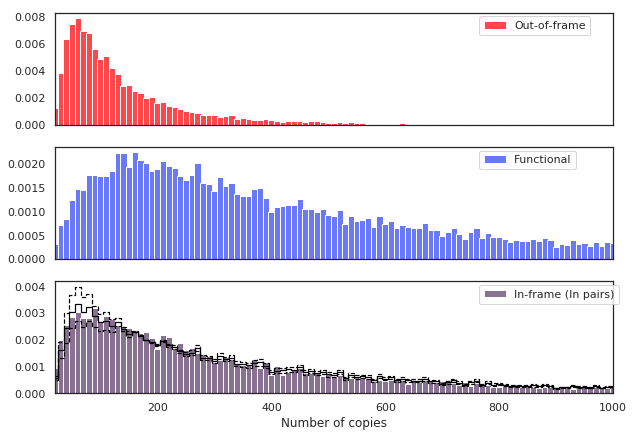

In [6]:
sns.set(palette="deep", style="white")
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 7), sharex=True)

ax1.bar(nplin, hOut, label="Out-of-frame",
                 color='xkcd:light red', alpha=1, width=N/nbbins*1.1)

ax2.bar(nplin, hE, label="Functional", 
                 color='xkcd:cornflower', alpha=1, width=(N/nbbins)*1.1)


ax3.bar(nplin,hInin, label="In-frame (In pairs)",
                 color='xkcd:greyish purple', alpha=1, width=(N/nbbins)*1.1)
ax3.step(nplin,fitresm10, 
             linewidth=1.2, color='xkcd:black', where='mid',linestyle='dashed')
ax3.step(nplin,fitresp10, 
            linewidth=1.2, color='xkcd:black', where='mid',linestyle='dashed')
ax3.step(nplin,fitres, 
             linewidth=1.2, color='xkcd:black', where='mid')

ax1.set(xlim=(Nmin, N), xlabel="")
ax1.legend(loc=(0.76,0.8))
ax2.set(xlim=(Nmin, N-10), xlabel="")
ax2.legend(loc=(0.76,0.8))
ax3.set(xlim=(Nmin, N-N/nbbins), xlabel="Number of copies")
ax3.legend(loc=(0.76,0.8))
plt.xlim([20,1000])
plt.show()
